In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# load map, salaries, ISO 3166
world_data = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
salaries_data = pd.read_csv('../data/salaries.csv')
countries_data = pd.read_csv('../data/countries.csv')

In [101]:
# profile report of data for initial manual inspaction
from pandas_profiling import ProfileReport
profile = ProfileReport(salaries_data, title="Pandas Profiling Report")
profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


In [3]:
# merge dataframes
salaries = pd.merge(salaries_data, countries_data, left_on='company_location', right_on='iso_a2').drop(['iso_a2', 'id', 'name'], axis=1).rename(columns = {'iso_a3':'company_location_iso_a3'})
salaries = pd.merge(salaries, countries_data, left_on='employee_residence', right_on='iso_a2').drop(['iso_a2', 'id', 'name', 'company_location', 'employee_residence'], axis=1).rename(columns = {'iso_a3':'employee_residence_iso_a3'})
salaries.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,remote_ratio,company_size,company_location_iso_a3,employee_residence_iso_a3
0,2021e,MI,FT,Data Scientist,82500,USD,82500,100,S,USA,USA
1,2021,SE,FT,Information Security Engineer,104000,USD,104000,100,L,USA,USA
2,2021,MI,FT,IT Security Analyst,115500,USD,115500,100,L,USA,USA
3,2022e,EN,FT,Cybersecurity Analyst,52000,USD,52000,50,S,USA,USA
4,2021,MI,FT,Information Security Specialist,68900,USD,68900,100,L,USA,USA


<AxesSubplot:>

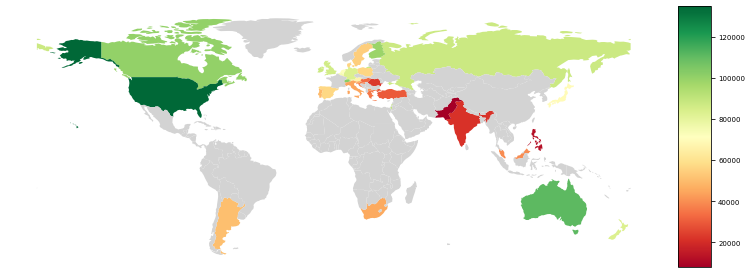

In [18]:
from tueplots import bundles

salaries_count_per_country = salaries[['company_location_iso_a3', 'salary_in_usd']].groupby('company_location_iso_a3').count()
avg_salaries_by_country = salaries[['company_location_iso_a3', 'salary_in_usd']].groupby('company_location_iso_a3').mean()
avg_salaries_by_country = pd.merge(avg_salaries_by_country, salaries_count_per_country, left_index=True, right_index=True, how='left')

# filter out values with less than N datapoints
avg_salaries_by_country = avg_salaries_by_country[avg_salaries_by_country['salary_in_usd_y'] >= 3]
#print(avg_salaries_by_country)

# merge with map
world = world_data[world_data.name!="Antarctica"]
world_salaries = pd.merge(world, avg_salaries_by_country, left_on='iso_a3', right_index=True, how='left')

# plot
plt.rcParams.update(bundles.neurips2021(usetex=False))

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world_salaries.plot(ax=ax, column='salary_in_usd_x', cmap='RdYlGn', missing_kwds={'color': 'lightgrey'}, legend=True, cax=cax)

In [9]:
gdp_data = world[['iso_a3', 'gdp_md_est', 'pop_est']]
gdp_data['gdp_per_capita'] = (gdp_data['gdp_md_est'] / gdp_data['pop_est'] * 1000000)
gdp_data = gdp_data.drop({'gdp_md_est', 'pop_est'}, axis=1)

df = pd.merge(salaries, gdp_data, left_on='company_location_iso_a3', right_on='iso_a3', how='left').rename(columns = {'gdp_per_capita':'gdp_company_location'})
df = pd.merge(df, gdp_data, left_on='employee_residence_iso_a3', right_on='iso_a3', how='left').rename(columns = {'gdp_per_capita':'gdp_employee_residence'})
#df.tail(20)

/var/folders/ct/c6nl4fhx7hx43w75240zn_140000gn/T/ipykernel_14172/2613105571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_data['gdp_per_capita'] = (gdp_data['gdp_md_est'] / gdp_data['pop_est'] * 1000000)


In [39]:
ai = pd.read_csv('../data/ai-salaries.csv')
rm = pd.read_csv('../data/salaries.csv')

ai.drop({'work_year'}, axis=1, inplace=True)
rm.drop({'work_year'}, axis=1, inplace=True)

sim = pd.merge(ai, rm, left_on=['experience_level',
                                'employment_type',
                                'job_title',
                                'salary',
                                'salary_currency',
                                'salary_in_usd',
                                'employee_residence',
                                'remote_ratio',
                                'company_location',
                                'company_size'],
                        right_on=['experience_level',
                                'employment_type',
                                'job_title',
                                'salary',
                                'salary_currency',
                                'salary_in_usd',
                                'employee_residence',
                                'remote_ratio',
                                'company_location',
                                'company_size'], how='left')

sim.head()

,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,EN,FT,Financial Data Analyst,100000,USD,100000,US,50,US,L
1,MI,FT,Data Scientist,82500,USD,82500,US,100,US,S
2,EN,FT,Data Scientist,42000,EUR,49646,FR,50,FR,M
3,SE,FT,Lead Data Scientist,3000000,INR,40570,IN,50,IN,L
4,EN,FT,Data Engineer,120000,USD,120000,US,100,US,M


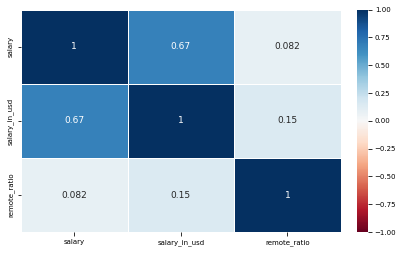

In [36]:
import seaborn as sns

import matplotlib.pyplot as plt

plt.rcParams.update(bundles.neurips2021(usetex=False))

heatmap = sns.heatmap(salaries.corr(method='spearman'), annot=True, cmap='RdBu', vmin=-1, vmax=1, linewidths=.5)

#hm.set(xlabel='IRIS Flower Details', ylabel='IRIS Flower Details', title = "Correlation matrix of IRIS data")

plt.show()